# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

Загружаем библиотеки, подгружаем алгоритм обучения модели, функцию разбиения выборок и метрики качетв

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

Смотрим данные. Полноту картины по ним оценить нельзя, равзве что о цифре запасах по каждому из месторождений в столбце product

In [2]:
geo_data_0 = pd.read_csv('/datasets/geo_data_0.csv')
geo_data_1 = pd.read_csv('/datasets/geo_data_1.csv')
geo_data_2 = pd.read_csv('/datasets/geo_data_2.csv')

Пропусков нет, единственное есть столбец id, который не несет существенной информации и в рамках поставленной задачи его можно удалить.

In [3]:
geo_data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


Так как мы работаем в ГлавРосГосНефть, условимся что и проекты будут внутри России. Для вхождения в отечественные проекты минимальные извлекаемые запасы принято считать рентабельными если они больше 1 млн. м3, что в баррелях 6.3 млн или 6300 тыс баррелей нефти. Если учесть, что скороее всего нам предоставили начальные геологические запасы, то для получения извлекаемых надо умножить величины запасов на  коэфициент извлечения нефти, который равен +- 0.2. Итого получаем, что максимальные запасы по предложеным месторождениям составляют меньше 50 тыс. баррелей (а нам надо минимум 6300 тыс. баррелей для рентабельного входа в проект). **Вывод**: ни одно из предложенных месторождений никогда себя не окупит). 

Минутка отсылок к моей трудовой деятельности закончилась, теперь можно начать обучение модели.

# 2. Обучение и проверка модели

**Составим функцию обучения модели, на вход которой будем подавать интересующию выборку**
- Для обучения модели воспользуемся линейной регрессией;
- Из исходных выборок получим features и target путем отбрасывания и сохранения столбца product соответственно;
- Разобьем выборки на тренеровочные и валидационные в отношении 3 к 1 методом train_test_split
- Обучим модель методом .fit()
- Предскажем искомые данные product
- Найдем средннее значение предсказанных запасов по региону
- Найдем RMSE для пресказанных и истинных велчини, выведем их на экран

In [4]:
def LR_model(data):
    features = data.drop(['id','product'], axis = 1)
    target = data['product']
    
    features_train, features_valid, target_train, target_valid= train_test_split(features,target, test_size = 0.25,
                                                                                 random_state=12345 )

    model = LinearRegression()
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    
    #STOIIP - Abbreviation for stock-tank oil initially in place, the volume of oil in a reservoir prior to production
    print("STOIIP_mean =", predicted_valid.mean())
    
    mse = mean_squared_error(target_valid, predicted_valid)
    rmse = mse ** 0.5
    #print("MSE =", mse)
    print("RMSE =", mse ** 0.5)
    
    predicted_valid = pd.DataFrame(predicted_valid,columns = ["predicted_product"])
    return predicted_valid, predicted_valid.mean(), rmse 

- Воспользуемся написанной функцией для интересующих регионов.

In [5]:
predicted_valid_0, STOIIP_mean_0, rmse_0= LR_model(geo_data_0)

STOIIP_mean = 92.59256778438038
RMSE = 37.5794217150813


In [6]:
predicted_valid_1, STOIIP_mean_1, rmse_1 = LR_model(geo_data_1)

STOIIP_mean = 68.728546895446
RMSE = 0.893099286775616


In [7]:
predicted_valid_2, STOIIP_mean_2, rmse_2= LR_model(geo_data_2)

STOIIP_mean = 94.96504596800489
RMSE = 40.02970873393434


 - Меньший разброс по запасам на месторождениях дает 1 регион, но вместе с этим и наименьшее среднее. Наибольшее срденее у 2 региона, но и разброс тоже больше. Нужно провести анализ финансовой составляющей чтобы сказать какой регион будет наиболее вероятнее комерчески успешен

# 3. Подготовка к расчёту прибыли

- Посчитаем минимальные рентабельные запасы для разработки месторождения

In [8]:
STOIIP_min = 50000000 / 4500 /1000
print("Минимальные рентабельные запасы м-ия для разработки одной скважиной {:.2f} тыс.баррелей.".format(STOIIP_min))

Минимальные рентабельные запасы м-ия для разработки одной скважиной 11.11 тыс.баррелей.


*Вообще эта цифра показывает, какую минимальную накопленную добычу должна иметь скважина, чтобы себя окупить. Но так как мы не знаем средние суточные дебиты, то нет возможности понять за какой период произойдет отбор. Еще важнее было бы знать среднею накопленую добычу на скважину по региону, тогда мы бы могли расчитать сколькими скважинами нужно разрабатывать месторождение и  расчет прибыли был бы по прежнему грубым но идейно верным.*

Составим функцию для нахождения выручки. Выручку считаем из условия, что месторождение разрабатывается 1 скважиной, эта скважина отбирает все запасы.
 - Считаем столбец total_revenue, который показывает ссумму на которую можно продать всю нефть на месторождении (валовую прибыль)
 - Считаем чистую прибыль в столбеце income, который получаем как разницу валовой выручки и капитальных затрат на строительство скважины.

In [9]:
def revenue_calc(data):
    data['total_revenue'] = data['predicted_product'] *4500*1000/1000000
    data['cost_of_well'] = 50
    data['income'] = data['total_revenue'] - data['cost_of_well']
    return data

- Применяем функцию для каждого региона

In [10]:
predicted_valid_0 =revenue_calc(predicted_valid_0)
predicted_valid_1 = revenue_calc(predicted_valid_1)
predicted_valid_2 = revenue_calc(predicted_valid_2)

In [11]:
predicted_valid_2.head()

,predicted_product,total_revenue,cost_of_well,income
0,93.599633,421.198349,50,371.198349
1,75.105159,337.973213,50,287.973213
2,90.066809,405.300642,50,355.300642
3,105.162375,473.230688,50,423.230688
4,115.303310,518.864897,50,468.864897


- Смотрим, количесвто отрицательных по экономике местородений в регионе, делаем это методом query

In [12]:
predicted_valid_0.query("income < 0")['income'].count()

5

In [13]:
predicted_valid_1.query("income < 0")['income'].count()

4146

In [14]:
predicted_valid_2.query('income < 0')['income'].count()

0

**Вывод:** 
- Второй регион, может показаться менее привлекательным, так как имеем 4146  из 25000 отрицательных по экономике месторождений.
- Третий регион сплош положительный, будем делать ставку на него

# 4. Расчёт прибыли и рисков 

**Составим функцию с применненой в ней техникой Bootstrap**
- На вход функции подаем обученную выборку, и номер региона
- Создаем пустой лист values_sum
- В цикле из 1000 повторений берем 500 рандомных строк с возвращением из представленных валидационных выборок (25000 строк) 
- На каждом этапе цикла для выброного сабсета считаем с сумму с 500 и добавляем данные  в созданный пустой лист.

- После выхода их цикла строим график распределения средних из выборок и выводим 95% доверительный интервал также выводим среднее значение дохода из срдених всех выборок.


In [15]:
def cofidence_int(sample, region):
    state = np.random.RandomState(12345)
    values_sum = []
    for i in range(1000):
        subsample = sample.sample(n = 500, replace=True, random_state=state)
        values_sum.append(subsample['income'].sum())
        
    values_sum = pd.Series(values_sum)
    sns.distplot(values_sum, kde=True, rug=False, color = 'b');
    print("Total incmome for region from 500 oilfields {} is {:.1f} MM rub.".format(region, values_sum.mean()))
    print("95% confidence interval of total imcome for the region {} is between {:.1f} and {:.1f} MM rub.".format(
        region,values_sum.quantile(.025),values_sum.quantile(.975)))   
    

Применяем функцию для обученной выборки с трех регионов.

Total incmome for region from 500 oilfields 0 is 183350.1 MM rub.
95% confidence interval of total imcome for the region 0 is between 178901.0 and 187864.1 MM rub.


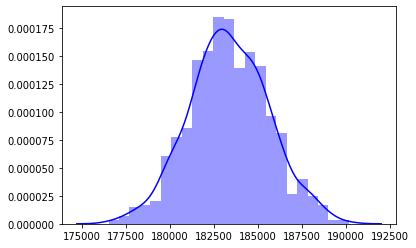

In [16]:
cofidence_int(predicted_valid_0, 0)

Total incmome for region from 500 oilfields 1 is 129547.0 MM rub.
95% confidence interval of total imcome for the region 1 is between 119843.0 and 138340.1 MM rub.


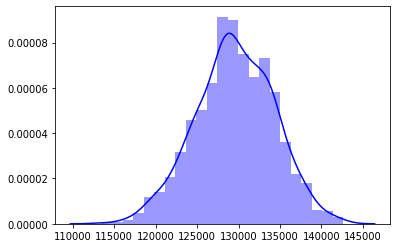

In [17]:
cofidence_int(predicted_valid_1, 1)

Total incmome for region from 500 oilfields 2 is 188780.1 MM rub.
95% confidence interval of total imcome for the region 2 is between 184712.8 and 192765.1 MM rub.


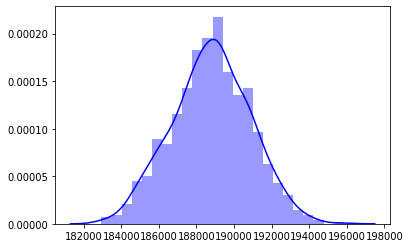

In [18]:
cofidence_int(predicted_valid_2, 2)

**Вывод**
- Второй регион самый перспектиный с ожидаемой средней выручкой с 500 месторождений 188780.1 ММ рублей и 95% доверетельным интревалом в границах  м/у 184712.8 и 192765.1 MM рублей. Риски по данному региону отсутсвуют так как мы выяснили, что отрицательная экономика при выбранных условиях для этого региона равна 0 случаев.
- Первый регион имеет наименьшее среднее по запасам с следовательно и прибыли + там встречаются отрицательные по экономике кейсы, этот регион рекомендовать нельзя.
- Так как на разработку месторождений у нас есть 10 млрд рублей, то это 200 пробуренных скважин = 200 разработанных месторождений, соответсвенно от бутстраповой выручки возьмем 40% (200/500х100%) и получаем что с заложенным бюджетом в 10 млрд рублей со второго региона может получить 75 млрд руб. Те выбранный регион окупит себя на 750% при данной экономической модели. Одним словом - нефтянка это выгодно.

# Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован